In [2]:
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
import statsmodels.api as sm
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [19]:
# adata minimize weighted
adata=schist.io.read('../scRNA_paga/state_adata/10XV3_minimize_weighted')

In [3]:
# adata minimize unweighted 
adata=schist.io.read('../scRNA_paga/state_adata/10XV3_minimize')

# 1) Differential Gene Expression analysis 
Visualization of data using a cell-affinity derived cut off

In [50]:
M=adata_d.uns['nsbm']['cell_affinity']['2']
adata_d.obs['max_u'] = 1 - np.max(M, axis=1)

In [51]:
ciao3=adata_d[adata_d.obs.max_u < 1e-100]

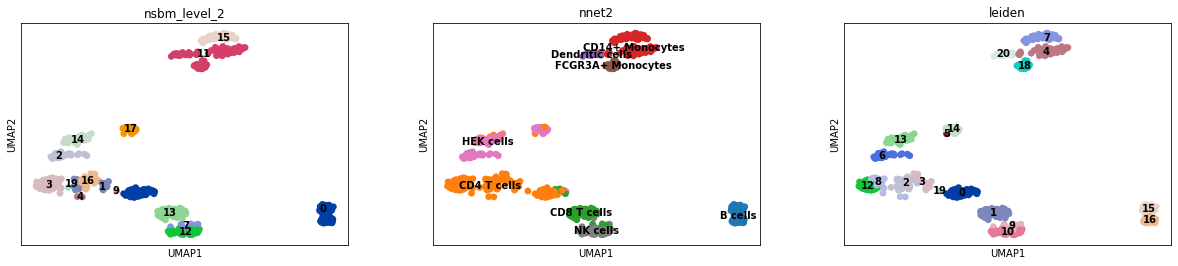

In [52]:
sc.pl.umap(ciao3,color=['nsbm_level_2','nnet2','leiden'], legend_loc='on data')

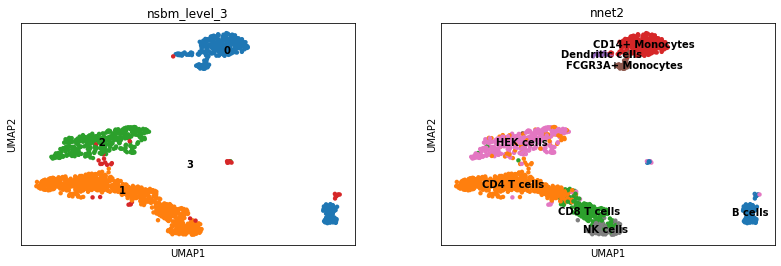

In [23]:
sc.pl.umap(adata,color=['nsbm_level_1','nnet2'],legend_loc='on data')

### Linear Flat Model for differential gene analysis
Firstly we have analyzed data using a linear flat model: for each group are derived genes p-values, and only significative gene are mantained for the analysis; for each significative gene is calculated also its adjusted p-value.



Morover, our aim was to understand if changes in the spectrum of significative genes occurred, when cells were selected upon their cell-affinity measure: therefore, we set several thresholds based on cell-affinity measures, in this way at each threshold some cells were discarted from the analysis.



At the end of the process, we obtained a python dictionary where each key is the one of the threshold and its associated value is another dictionary. The latter dictionary is composed by the number of cells analyzed with a specific threshold and the information for each group in the sample. The value associated with each group key is another dictionary: here it can be observed the number of cells in the group; gene names of significative genes; their p-values and thei adjusted p-values.

In [13]:
marginals = adata.uns['nsbm']['cell_affinity']['2']     
groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) 
expr_values = adata.X
flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
flat_results = [x.fit() for x in flat_model]
flat_scores = np.array([x.params[1:] for x in flat_results])
flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T
gene_names = []
gene_scores = []
gene_pvalues = []
gene_fdr = []
gene_foldchange = []
for x in range(flat_scores.shape[1]):
    up_mask = flat_scores[:, x] > 0
    scores = flat_scores[up_mask, x]
    pvals = flat_pvals[up_mask, x]
    genes = np.array(adata.var_names)[up_mask]
    fdr = flat_fdr[up_mask, x]
    selected = np.argsort(fdr)
    order = np.argsort(scores[selected])[::-1]
    gene_names.append(genes[selected][order])
    gene_scores.append(scores[selected][order])
    gene_pvalues.append(pvals[selected][order])
    gene_fdr.append(fdr[selected][order])
    gene_foldchange.append(scores[selected][order])

In [14]:
categ=adata.obs.nsbm_level_2
e=dict()
e['n_cells']=e.get('n_cells',len(adata.obs.index))
for i in range(len(categ.cat.categories)):
    e[categ.cat.categories[i]]=e.get(categ.cat.categories[i],{})
    count=0
    for s in categ:
        if s==categ.cat.categories[i]:
            count=count+1
    e[categ.cat.categories[i]]['n_obs']=e[categ.cat.categories[i]].get('n_obs', count)
    sel_p=[]
    sel_g=[]
    sel_s=[]
    for x in range(len(gene_fdr[i])):
        if gene_fdr[i][x]<0.05:
            sel_p.append(gene_fdr[int(i)][x])
            sel_g.append(gene_names[int(i)][x])
            sel_s.append(gene_scores[int(i)][x])
    e[categ.cat.categories[i]]['n_significative']=e[categ.cat.categories[i]].get('n_significative', len(sel_g))
    e[categ.cat.categories[i]]['scores']=e[categ.cat.categories[i]].get('scores', sel_s)
    e[categ.cat.categories[i]]['gene_names']=e[categ.cat.categories[i]].get('gene_names', sel_g)
    e[categ.cat.categories[i]]['pvals_adj']=e[categ.cat.categories[i]].get('pvals_adj', sel_p)
e

{'n_cells': 1523,
 '0': {'n_obs': 88,
  'n_significative': 525,
  'scores': [3.42853770865543,
   3.299234903096945,
   3.26970084161571,
   3.2643296468337963,
   3.232763739338966,
   3.158879620290082,
   3.10502789643942,
   3.0120331466453765,
   2.9959148974451426,
   2.9409436736313,
   2.908364043474874,
   2.8204217617405885,
   2.742174078519737,
   2.705162167904092,
   2.6755667070818467,
   2.6724612143534805,
   2.651270615468827,
   2.305895161360648,
   2.283596056885505,
   2.2625054350517586,
   2.226989762460045,
   2.1974669223286325,
   2.1690901907413043,
   2.160529148061323,
   2.136318174661587,
   2.089014829710304,
   2.0881217739676377,
   2.0804266431155796,
   2.0730238785707154,
   2.064938887628991,
   2.0351392642292576,
   2.014666885678808,
   1.9860153451225948,
   1.9807705416808907,
   1.9673963197284094,
   1.9659498315260515,
   1.9347671074287416,
   1.909469480022913,
   1.8923902256326977,
   1.8703007060730146,
   1.8261610611197596,
   1.819

In [15]:
pickle.dump(e,open('cell_affinity_significance/minimize_linear_flat_10XV3_l2.pkl','wb'),2)

### Linear Weighted Model for differential gene analysis
The weighted model uses the information coming from cell-affinities in order to weight cells in each group: cells with stronger affinities weigths more than cells with low affinity value. In this way in each group cells with the highest uncerteinty are not taken into account for the differential gene expression analysis.

In [9]:
adata=adata.copy()

In [16]:
marginals = adata.uns['nsbm']['cell_affinity']['2'] 
groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) 
expr_values = adata.X
weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
weight_results = [x.fit() for x in weight_model]


weight_scores = np.array([x.params[1:] for x in weight_results])
weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T
gene_names = []
gene_scores = []
gene_pvalues = []
gene_fdr = []
for x in range(weight_scores.shape[1]):
    up_mask = weight_scores[:, x] > 0
    scores = weight_scores[up_mask, x]
    pvals = weight_pvals[up_mask, x]
    genes = np.array(adata.var_names)[up_mask]
    fdr = weight_fdr[up_mask, x]
    selected = np.argsort(fdr)[:]
    order = np.argsort(scores[selected])[::-1]
    gene_names.append(genes[selected][order])
    gene_scores.append(scores[selected][order])
    gene_pvalues.append(pvals[selected][order])
    gene_fdr.append(fdr[selected][order])

In [17]:
categ=adata.obs.nsbm_level_2
e=dict()
e['n_cells']=e.get('n_cells',len(adata.obs.index))
for i in range(len(categ.cat.categories)):
    e[categ.cat.categories[i]]=e.get(categ.cat.categories[i],{})
    count=0
    for s in categ:
        if s==categ.cat.categories[i]:
            count=count+1
    e[categ.cat.categories[i]]['n_obs']=e[categ.cat.categories[i]].get('n_obs', count)
    sel_p=[]
    sel_g=[]
    sel_s=[]
    for x in range(len(gene_fdr[i])):
        if gene_fdr[i][x]<0.05:
            sel_p.append(gene_fdr[int(i)][x])
            sel_g.append(gene_names[int(i)][x])
            sel_s.append(gene_scores[int(i)][x])
    e[categ.cat.categories[i]]['n_significative']=e[categ.cat.categories[i]].get('n_significative', len(sel_g))
    e[categ.cat.categories[i]]['scores']=e[categ.cat.categories[i]].get('scores', sel_s)
    e[categ.cat.categories[i]]['gene_names']=e[categ.cat.categories[i]].get('gene_names', sel_g)
    e[categ.cat.categories[i]]['pvals_adj']=e[categ.cat.categories[i]].get('pvals_adj', sel_p)
e

{'n_cells': 1523,
 '0': {'n_obs': 88,
  'n_significative': 523,
  'scores': [3.430415805475161,
   3.300990159841727,
   3.273724933992156,
   3.260859330893799,
   3.2339830529673566,
   3.16238388388734,
   3.106624150141972,
   3.013820158015697,
   2.997403009409057,
   2.942942901027737,
   2.9041270160631196,
   2.8219056003655223,
   2.7455571210360437,
   2.706952063323333,
   2.6781307518771627,
   2.6741334121413343,
   2.6527544545577855,
   2.307302247293252,
   2.284258188777943,
   2.2612477556878274,
   2.2285380521500433,
   2.199416285308505,
   2.1705892311100348,
   2.161028046503255,
   2.136815974215259,
   2.090457535921555,
   2.0893771989026133,
   2.07413993091936,
   2.0723158733545883,
   2.0667995309178173,
   2.0372447543520735,
   2.0123879814800256,
   1.9867536122702707,
   1.9826765356920448,
   1.9687133182236036,
   1.963563072809674,
   1.937528852331814,
   1.9113042602046069,
   1.8945785223773512,
   1.8713368657171092,
   1.8284863697004554,
   1

In [18]:
e['6']

{'n_obs': 251,
 'n_significative': 842,
 'scores': [2.2024474776947836,
  2.0559712205948197,
  1.9222802937407948,
  1.9199819407989598,
  1.8560482358913715,
  1.8088594371571733,
  1.806040411515227,
  1.7760496606944425,
  1.6560902472339987,
  1.6543618258132968,
  1.5659940054931765,
  1.5463150732654434,
  1.5253452540385886,
  1.5136494999801031,
  1.5080594409979218,
  1.430636836195909,
  1.4050398276002487,
  1.3756922654972188,
  1.3494616626966125,
  1.329364857060596,
  1.3237466381356797,
  1.3032260488962808,
  1.2966959461195742,
  1.2863654000293463,
  1.2819940232657967,
  1.2656242721237967,
  1.2285050933730215,
  1.2091780259450784,
  1.1920045518745963,
  1.1902425929148808,
  1.1838665235334453,
  1.1787814697242178,
  1.1771436011417553,
  1.1731515439514713,
  1.164480753164371,
  1.1519876743173068,
  1.1476953858526306,
  1.1308006092429383,
  1.1112495008756411,
  1.1085400929729283,
  1.101260160384993,
  1.0997284695153924,
  1.0995961337621212,
  1.08517

In [12]:
pickle.dump(e,open('cell_affinity_significance/minimize_linear_weighted_10XV3_l2.pkl','wb'),2)

# 2) Matrix with p-values of all genes for all cells
Here we create a matrices containg the p-value or the adjusted p-value for each gene in each cells. Then, we visualize these information through an histogram for each group: if the group has got many genes that are significantly expressed, the first bar of the histogram is high.
We should observe more significative gene in the weighted model compared to the flat one.

In [17]:
adata=adatam

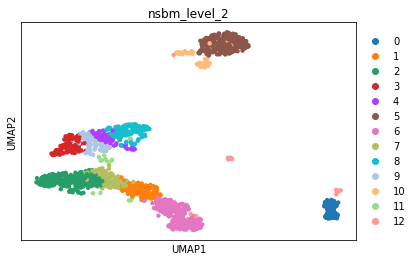

In [21]:
sc.pl.umap(adata,color='nsbm_level_2')

### Flat Model

In [26]:
for level in range(1,4):
    marginals = adata.uns['nsbm']['cell_affinity'][str(level)] 
    groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{level}', drop=True) 
    expr_values = adata.X
    flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
    flat_results = [x.fit() for x in flat_model]
    flat_scores = np.array([x.params[1:] for x in flat_results])
    flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
    flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T
    np.savez(f'cell_affinity_significance/10XV3_flat_level_{level}.npz', scores=flat_scores, pvals=flat_pvals, fdr=flat_fdr)

(array([2097.,  391.,  262.,  280.,  243.,  249.,  202.,  219.,  128.,
         134.,  148.,  146.,  135.,  164.,  163.,  159.,  145.,  109.,
         143.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

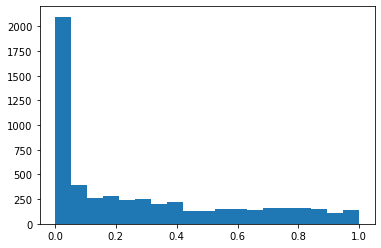

In [25]:
hist(f_padj_l1[:,6],bins=np.linspace(0,1,20))

### Weighted Model

In [20]:
for level in range(1,4):
    marginals = adata.uns['nsbm']['cell_affinity'][str(level)] 
    groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{level}', drop=True) 
    expr_values = adata.X
    weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
    weight_results = [x.fit() for x in weight_model]
    weight_scores = np.array([x.params[1:] for x in weight_results])
    weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
    weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T
    np.savez(f'cell_affinity_significance/w10XV3_weighted_level_{level}.npz', scores=weight_scores, pvals=weight_pvals, fdr=weight_fdr)

(array([2071.,  431.,  274.,  264.,  262.,  219.,  243.,  172.,  174.,
         123.,  152.,  143.,  125.,  141.,  163.,  136.,  157.,  132.,
         135.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

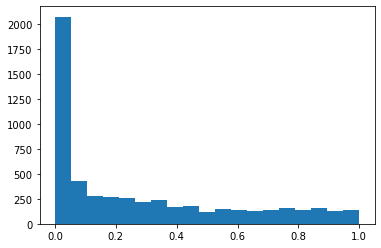

In [24]:
hist(w_padj_l1[:,6],bins=np.linspace(0,1,20))

### Scanpy
In order to be sure that our approach for differential gene expression analysis is good, we made a comparison with scanpy tool for differential gene expression analysis

In [16]:
sc.tl.rank_genes_groups(adatam,groupby='nsbm_level_2',n_genes=-1)

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


(array([6.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 2.000e+00,
        7.000e+00, 0.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 3.000e+00,
        0.000e+00, 4.000e+00, 1.600e+01, 1.500e+01, 7.000e+00, 2.900e+01,
        5.396e+03]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

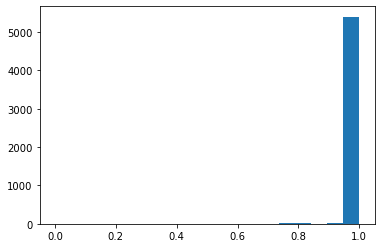

In [37]:
hist([adatam.uns['rank_genes_groups']['pvals_adj'][x][9] for x in range(5516)],bins=np.linspace(0,1,20))

In [39]:
# adata minimize weighted
adata=schist.io.read('../scRNA_paga/state_adata/10XV3_minimize_weighted')

In [50]:
for thr in [0,0.5,0.6,0.7,0.8,0.9,0.95,0.99,0.999]:    
    adata=schist.io.read('../scRNA_paga/state_adata/10XV3_minimize_weighted')
    marginals = adata.uns['nsbm']['cell_affinity'][str(1)] 
    for i in range(len(marginals)):
        for j in range(len(marginals[i])):
            if marginals[i][j]<thr:
                marginals[i][j]=0
    level=1
    groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{level}', drop=True) 
    expr_values = adata.X
    weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
    weight_results = [x.fit() for x in weight_model]
    weight_scores = np.array([x.params[1:] for x in weight_results])
    weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
    weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T
    significative=0
    for group in adata.obs.nsbm_level_1.cat.categories:
        sig_level=len([x for x in weight_pvals[:,int(group)] if x <0.05])
        significative=significative+sig_level
    print(significative)

24619
9916
13213
16035
17044
17874
18686
19440
19254


(array([470., 209., 218., 219., 198., 235., 246., 218., 242., 272., 294.,
        305., 313., 323., 354., 335., 353., 340., 373.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

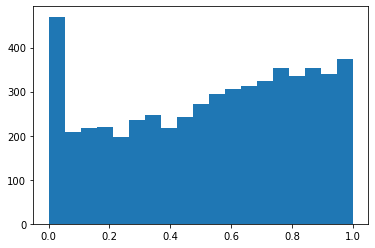

In [64]:
hist(f_pvals_l1[:,16],bins=np.linspace(0,1,20))

(array([325., 183., 169., 219., 200., 236., 248., 243., 258., 289., 272.,
        300., 341., 335., 346., 383., 406., 363., 401.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

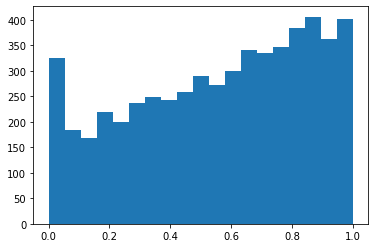

In [65]:
hist(weight_pvals[:,16],bins=np.linspace(0,1,20))